<a href="https://colab.research.google.com/github/akinahomwabella/Data-Imputation-Numerical-Analysis-in-Data-Science/blob/main/Twitter_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import kagglehub
import os

# Download the dataset
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

# Check if the downloaded path exists and handle the dataset
if os.path.exists(path):
    print(f"Dataset downloaded to: {path}")

    # Find the training and validation CSV files
    training_file = os.path.join(path, "twitter_training.csv")
    validation_file = os.path.join(path, "twitter_validation.csv")

    # Define custom column names since the dataset has no header
    column_names = ["Tweet ID", "entity", "sentiment", "Tweet content"]

    # Read the CSV files into DataFrames
    if os.path.exists(training_file) and os.path.exists(validation_file):
        training_data = pd.read_csv(training_file, header=None, names=column_names)
        validation_data = pd.read_csv(validation_file, header=None, names=column_names)
        print("Training and validation datasets loaded.")
    else:
        print("Error: twitter_training.csv or twitter_validation.csv not found in the downloaded dataset.")
else:
    print("Failed to download the dataset.")

# Encoding the 'entity' and 'sentiment' columns
encoder_entity = LabelEncoder()
encoder_sentiment = LabelEncoder()

# Fit on the training data and transform both datasets
training_data['entity_encoded'] = encoder_entity.fit_transform(training_data['entity'])
validation_data['entity_encoded'] = encoder_entity.transform(validation_data['entity'])

training_data['sentiment_encoded'] = encoder_sentiment.fit_transform(training_data['sentiment'])
validation_data['sentiment_encoded'] = encoder_sentiment.transform(validation_data['sentiment'])

# Define interpolation functions
def linear_interpolation(data, column):
    return data[column].interpolate(method='linear').bfill().ffill()

def spline_interpolation(data, column, order=3):
    return data[column].interpolate(method='spline', order=order).bfill().ffill()

def knn_imputation(data, column, n_neighbors=5):
    temp_data = data.copy()
    imputer = KNNImputer(n_neighbors=n_neighbors)
    temp_data[[column]] = imputer.fit_transform(temp_data[[column]])
    return temp_data[column]

# Step 2: Check for missing values
print("Missing values in training data:")
print(training_data.isnull().sum())

print("\nMissing values in validation data:")
print(validation_data.isnull().sum())

# Step 3: Apply interpolation
columns_to_interpolate = ['Tweet ID', 'entity_encoded', 'sentiment_encoded']

# Apply to training data
for column in columns_to_interpolate:
    if column in training_data.columns:
        training_data[f'{column}_linear'] = linear_interpolation(training_data, column)
        training_data[f'{column}_spline'] = spline_interpolation(training_data, column)
        training_data[f'{column}_knn'] = knn_imputation(training_data, column)

# Apply to validation data
for column in columns_to_interpolate:
    if column in validation_data.columns:
        validation_data[f'{column}_linear'] = linear_interpolation(validation_data, column)
        validation_data[f'{column}_spline'] = spline_interpolation(validation_data, column)
        validation_data[f'{column}_knn'] = knn_imputation(validation_data, column)

# Step 4: Save the cleaned datasets
training_data.to_csv('training_cleaned.csv', index=False)
validation_data.to_csv('validation_cleaned.csv', index=False)

print("\nCleaned datasets saved as 'training_cleaned.csv' and 'validation_cleaned.csv'.")


Dataset downloaded to: /root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2
Training and validation datasets loaded.
Missing values in training data:
Tweet ID               0
entity                 0
sentiment              0
Tweet content        686
entity_encoded         0
sentiment_encoded      0
dtype: int64

Missing values in validation data:
Tweet ID             0
entity               0
sentiment            0
Tweet content        0
entity_encoded       0
sentiment_encoded    0
dtype: int64

Cleaned datasets saved as 'training_cleaned.csv' and 'validation_cleaned.csv'.


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout
from textblob import TextBlob

# Step 1: Load the cleaned datasets
training_data = pd.read_csv('training_cleaned.csv')
validation_data = pd.read_csv('validation_cleaned.csv')

# Step 2: Feature Engineering
def extract_features(text):
    text=str(text)
    blob = TextBlob(text)
    return pd.Series({
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity,
        'length': len(text.split()),
        'hashtag_count': text.count('#')
    })

training_data_features = training_data['Tweet content'].apply(extract_features)
validation_data_features = validation_data['Tweet content'].apply(extract_features)

training_data = pd.concat([training_data, training_data_features], axis=1)
validation_data = pd.concat([validation_data, validation_data_features], axis=1)

# Step 3: Text Vectorization with TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
training_data['Tweet content'] = training_data['Tweet content'].fillna('')
validation_data['Tweet content'] = validation_data['Tweet content'].fillna('')

X_train_tfidf = vectorizer.fit_transform(training_data['Tweet content']).toarray()
X_val_tfidf = vectorizer.transform(validation_data['Tweet content']).toarray()

# Combine TF-IDF features with engineered features
X_train = np.hstack((X_train_tfidf, training_data_features))
X_val = np.hstack((X_val_tfidf, validation_data_features))

y_train = training_data['sentiment_encoded']
y_val = validation_data['sentiment_encoded']

# Step 4: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Step 5: Model Training and Evaluation

# Logistic Regression
lr_model = LogisticRegression(max_iter=500, class_weight='balanced')
lr_model.fit(X_train_balanced, y_train_balanced)
lr_predictions = lr_model.predict(X_val)
print("Logistic Regression Performance:")
print(classification_report(y_val, lr_predictions))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, class_weight='balanced')
rf_model.fit(X_train_balanced, y_train_balanced)
rf_predictions = rf_model.predict(X_val)
print("Random Forest Performance:")
print(classification_report(y_val, rf_predictions))

# Neural Network
nn_model = Sequential([
    Dense(512, activation='relu', input_dim=X_train_balanced.shape[1]),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train_balanced)), activation='softmax')
])
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, validation_split=0.2)

nn_predictions = nn_model.predict(X_val)
nn_predictions = np.argmax(nn_predictions, axis=1)
print("Neural Network Performance:")
print(classification_report(y_val, nn_predictions))

# Step 6: Evaluation and Analysis
print("\nConfusion Matrix for Logistic Regression:")
print(confusion_matrix(y_val, lr_predictions))

print("\nConfusion Matrix for Random Forest:")
print(confusion_matrix(y_val, rf_predictions))

print("\nConfusion Matrix for Neural Network:")
print(confusion_matrix(y_val, nn_predictions))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.58      0.59      0.58       172
           1       0.56      0.73      0.63       266
           2       0.66      0.59      0.62       285
           3       0.70      0.56      0.62       277

    accuracy                           0.62      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.63      0.62      0.62      1000

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.92      0.57      0.70       172
           1       0.63      0.84      0.72       266
           2       0.77      0.73      0.75       285
           3       0.73      0.72      0.73       277

    accuracy                           0.73      1000
   macro avg       0.76      0.71      0.73      1000
weighted avg       0.75      0.73      0.73      1000



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.4717 - loss: 1.2087 - val_accuracy: 0.6141 - val_loss: 0.9619
Epoch 2/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.6194 - loss: 0.9174 - val_accuracy: 0.6050 - val_loss: 0.9463
Epoch 3/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.6812 - loss: 0.7764 - val_accuracy: 0.7123 - val_loss: 0.7690
Epoch 4/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.7401 - loss: 0.6363 - val_accuracy: 0.7575 - val_loss: 0.6743
Epoch 5/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.7915 - loss: 0.5242 - val_accuracy: 0.7896 - val_loss: 0.6161
Epoch 6/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.8291 - loss: 0.4387 - val_accuracy: 0.7993 - val_loss: 0.5945
Epoch 7/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.8465 - loss: 0.3856 - val_accuracy: 0.7970 - val_loss: 0.5995
Epoch 8/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.8637 -

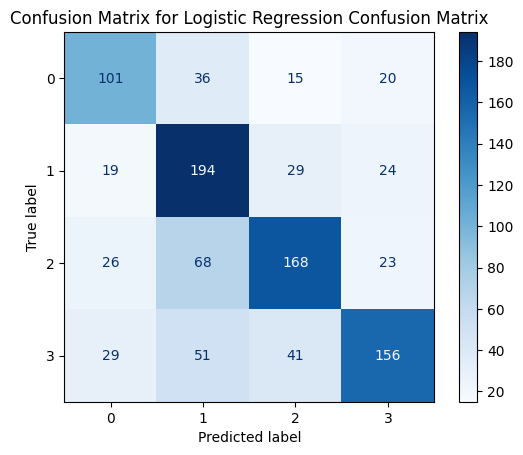

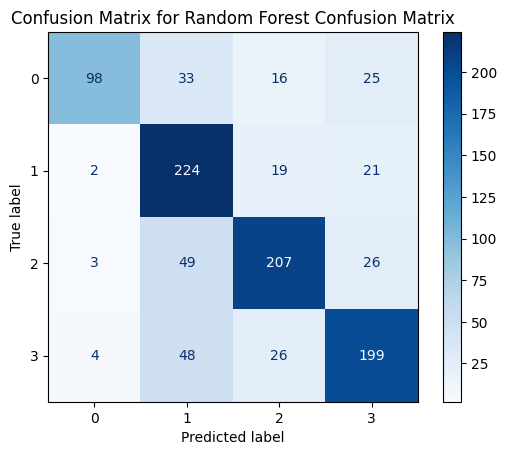

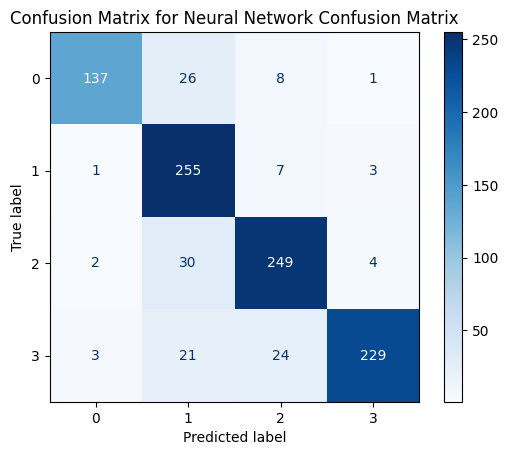

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(y_val, lr_predictions, "Logistic Regression Confusion Matrix")

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_val, rf_predictions, "Random Forest Confusion Matrix")

# Plot confusion matrix for Neural Network
plot_confusion_matrix(y_val, nn_predictions, "Neural Network Confusion Matrix")